# Checkers AI using Deep Q Learning
Author: Harsh Patel

Date: 04-29-2024

# Introduction 
#### Goal
> The goal for my project is to create a Checkers AI that is able to perform at an intermediate level. The model should be able to make optimal decisions in a game of Checkers. I really wanted to create something and a game is perfect, I chose a method called Deep Q learning to create this checker AI because I haven't really seen this method being applied to checkers(there are very few projects that use deep q learning to train a checkers ai like this one), and I wanted to explore something unique. Checkers is a very complex game with many possible states of the game, many different actions that can be taken in any given state, so I think the best way to create an AI capable of playing checkers is to make the AI learn strategies over many different states of the game and deep q learning allows the AI to learn in this manner. One of the major reasons I chose this method is because the AI creates its own data to be trained on through self-play, this is different from any deep learning methods I'm familiar with, and I think it's worth exploring. 
> (rules of checkers: https://www.usatoday.com/story/graphics/2023/01/23/how-to-play-checkers-rules-strategy/10795787002/)
#### Methodology

- I used a method called Deep Q(Quality) Learning, which is a reinforcement learning technique that combines Q-Learning, an algorithm for learning optimal actions in an environment, with deep neural networks.
- To create the checkers environment I used a youtube video that had a pygames implementation (https://www.youtube.com/watch?v=vnd3RfeG3NM&list=PLzMcBGfZo4-lkJr3sqpikNyVzbNZLRiT3). The classes Piece, Board, and Game were created through the use of this tutorial.

- Q-learning is a reinforcement learning technique a model is trained in a way animals or children learn. Good actions are rewarded/reinforced, while bad actions are discouraged and penalized. The model plays against itself and uses past experiences as data and the model tries to predict which actions will lead to be highest overall reward.

- In deep Q learning the two major elements are the **Agent** and the **Environment**. The agent (the AI) is being trained to interact with its environment, which would be the checkers game. The agent performs actions to get different states or scenarios. The agent is then rewarded or penalized for the action it took. The agent's goal is to maximize its reward during an episode (a game of checkers). 

 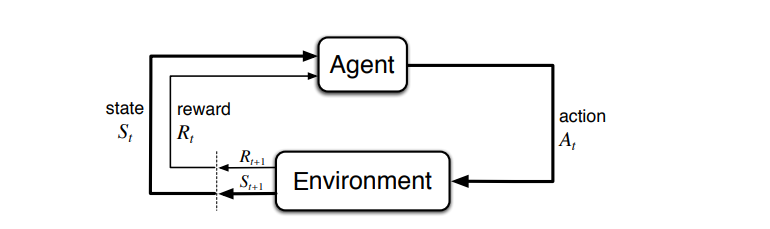

This image above is the Markov Decision Process: The Deep Q learning method works by utilizing the Markov Decision Process which can be described as so: First the agent performs an action, such as moving one piece from one square to another, on the environment which would be the checkers game. The environment then feeds the agent the state of the game such as in the form of a matrix, this would include where pieces are currently located on the board, and a reward/penalty for the action it took. The reward are points awarded to the agent for making a desirable action such as capturing an enemy piece.


Here are the needed downloads and imports:


In [31]:
# !pip install pygame
# !pip install numpy
# !pip install matplotlib
# !pip install torch

import pygame
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from collections import deque
import random
from itertools import combinations
import random
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import torch
import time

These are the constants which will be used throughout the code:

In [32]:
# Constants 
#Size of our display
WIDTH, HEIGHT = 800, 800
ROWS, COLS = 8, 8
SQUARE_SIZE = WIDTH//COLS

# Colors, RGB
RED = (255, 0 ,0)
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
BLUE = (0, 0, 255)
GREY = (128, 128, 128)
MAX_MOVES_ALLOWED = 70
CROWN = pygame.transform.scale(pygame.image.load('crown.png'), (45, 25))

### Class Description: Piece

The `Piece` class represents the individual checkers on the board. Each piece is has a position (row and column), color, and status as a king. Here's a breakdown of the class methods and attributes:

- `__init__(self, row, col, color)`: This method initializes the piece with its location on the board (`row` and `col`), its `color`, and sets the `king` status to `False` by default, the `king` status indicates whether a piece has been promoted to a king, which is done by a piece reaching the end of the board

- `calc_pos(self)`: Calculates the exact x and y coordinates of the piece based on its row and column, this method ensures that the piece is centered within a square on the board.

- `make_king(self)`: If a piece reaches the end of the board (the opponent's back row), this method promotes the piece to a king, which allows it to move both forward and backward.

- `draw(self, win)`: Renders the piece on the board using Pygame's drawing functions. It draws a filled circle with the piece's color and an outline. If the piece is a king, it also draws a crown on top of it.

- `move(self, row, col)`: Updates the piece's position on the board.

- `__repr__(self)`: Provides a string representation of the piece's color, which is useful for debugging and logging the state of the board.

Source: https://www.youtube.com/watch?v=vnd3RfeG3NM&list=PLzMcBGfZo4-lkJr3sqpikNyVzbNZLRiT3


In [33]:

class Piece:
    PADDING = 15
    OUTLINE = 2
    def __init__(self, row, col, color):
        self.row = row
        self.col = col
        self.color = color
        self.king = False
        self.x = 0
        self.y = 0
        self.calc_pos()

    def calc_pos(self):
        # our circular pieces should be in the middle of the square
        self.x = SQUARE_SIZE * self.col + SQUARE_SIZE // 2
        self.y = SQUARE_SIZE * self.row + SQUARE_SIZE // 2

    # makes a piece a king 
    def make_king(self):
        self.king = True

    def draw(self, win):
        radius = SQUARE_SIZE//2 - self.PADDING
        # draws a piece on a swaure
        pygame.draw.circle(win, self.color, (self.x, self.y), radius + self.OUTLINE)
        pygame.draw.circle(win, self.color, (self.x, self.y), radius)
        if self.king:
            win.blit(CROWN, (self.x - CROWN.get_width()//2, self.y - CROWN.get_height()//2))
    
    def move(self, row, col): 
        # to move th e peice we have to delete it and move it in that position
        self.row = row
        self.col = col
        self.calc_pos()

    
    def __repr__(self):
        # takes color as a str
        return str(self.color)

### Class Description: Board

The `Board` class is responsible for functions related to the game board for a Checkers game, it's responsible for managing the pieces on the board, handling moves, and determining the game state.



- `def __init__(self)`: Initializes the board with 12 pieces for each player positioned for the game start.
- `def draw_squares(self, win)`: Draws the checkered pattern on the board.
- `def move(self, piece, row, col)`: Moves a specified piece to a new board location. If moving the piece results in reaching the last row on the opponent's side, the piece is crowned as a king. This method directly manipulates the board state and updates the positions of pieces.
- `def get_piece(self, row, col)`: Retrieves the piece at the specified board coordinates, allowing for interaction with individual pieces during gameplay.
- `def create_board(self)`: creates the board with initial placements of pieces for a standard game of Checkers.
- `def reset(self))`: resets the board
- `def draw(self, win)`: Draws all the pieces on the board based on their current positions. This method ensures the board's visual representation is updated to reflect the state of the game after each move.
- `def remove(self, pieces)`: removes a captured piece from the board
- `def winner(self)`: Declares a winner when either side wins
- `def get_valid_moves(self, piece)`: Calculates legal moves for a selected piece according to the rules of Checkers.
- `def _traverse_left(self, start, stop, step, color, left, skipped=[])`: method that explore potential moves to the left from a given piece's position. 
- `def _traverse_right(self, start, stop, step, color, right, skipped=[])`: Same as the method above but traverses right
- `def count_pieces(self, color)`: Counts the total number of pieces of a specified color currently on the board


Source: https://www.youtube.com/watch?v=vnd3RfeG3NM&list=PLzMcBGfZo4-lkJr3sqpikNyVzbNZLRiT3


In [34]:
class Board:
    """
    This class represents the checkers game board. It handles the initialization of the board,
    drawing the board and pieces, moving pieces, capturing pieces, and determining the game's winner.
    """
    def __init__(self):
        """
        Initializes a new board with 12 pieces for each player.
        """
        self.board = [] # The game board array
        self.red_left = self.white_left = 12 # Pieces left for each player
        self.red_kings = self.white_kings = 0
        self.create_board()
    
    def draw_squares(self, win):
        """
        Draws the squares of the board.
        """
        win.fill(BLACK)
        for row in range(ROWS):
            for col in range(row % 2, COLS, 2):
                pygame.draw.rect(win, RED, (row*SQUARE_SIZE, col *SQUARE_SIZE, SQUARE_SIZE, SQUARE_SIZE))
    
    def move(self, piece, row, col):
        """
        Moves a piece to a new location on the board.
        """
        self.board[piece.row][piece.col], self.board[row][col] = self.board[row][col], self.board[piece.row][piece.col]
        piece.move(row, col)
        
        if row == ROWS - 1 or row == 0:
            piece.make_king()
            if piece.color == WHITE:
                self.white_kings += 1
            else:
                self.red_kings += 1 

    def get_piece(self, row, col):
        return self.board[row][col]

    def create_board(self):
        for row in range(ROWS):
            self.board.append([])
            for col in range(COLS):
                if col % 2 == ((row +  1) % 2):
                    if row < 3:
                        self.board[row].append(Piece(row, col, WHITE))
                    elif row > 4:
                        self.board[row].append(Piece(row, col, RED))
                    else:
                        self.board[row].append(0)
                else:
                    self.board[row].append(0)
    def reset(self):
        # Resets the board to its initial state
        self.create_board()  # Recreate the board setup for a new game
        return self.get_state()  # Return the initial state as a numeric representation
        
    def draw(self, win):
        self.draw_squares(win)
        for row in range(ROWS):
            for col in range(COLS):
                piece = self.board[row][col]
                if piece != 0:
                    piece.draw(win)

    def remove(self, pieces):
        for piece in pieces:
            self.board[piece.row][piece.col] = 0
            if piece != 0:
                if piece.color == RED:
                    self.red_left -= 1
                else:
                    self.white_left -= 1
    
    def winner(self):
        if self.red_left <= 0:
            return WHITE
        elif self.white_left <= 0:
            return RED
        
        return None 
    
    def get_valid_moves(self, piece):
        """
        Gets all valid moves for the specified piece using the game's rules.
        """
        moves = {}
        left = piece.col - 1
        right = piece.col + 1
        row = piece.row

        if piece.color == RED or piece.king:
            moves.update(self._traverse_left(row -1, max(row-3, -1), -1, piece.color, left))
            moves.update(self._traverse_right(row -1, max(row-3, -1), -1, piece.color, right))
        if piece.color == WHITE or piece.king:
            moves.update(self._traverse_left(row +1, min(row+3, ROWS), 1, piece.color, left))
            moves.update(self._traverse_right(row +1, min(row+3, ROWS), 1, piece.color, right))
    
        return moves

    def _traverse_left(self, start, stop, step, color, left, skipped=[]):
        moves = {}
        last = []
        for r in range(start, stop, step):
            if left < 0:
                break
            
            current = self.board[r][left]
            if current == 0:
                if skipped and not last:
                    break
                elif skipped:
                    moves[(r, left)] = last + skipped
                else:
                    moves[(r, left)] = last
                
                if last:
                    if step == -1:
                        row = max(r-3, 0)
                    else:
                        row = min(r+3, ROWS)
                    moves.update(self._traverse_left(r+step, row, step, color, left-1,skipped=last))
                    moves.update(self._traverse_right(r+step, row, step, color, left+1,skipped=last))
                break
            elif current.color == color:
                break
            else:
                last = [current]

            left -= 1
        
        return moves

    def _traverse_right(self, start, stop, step, color, right, skipped=[]):
        moves = {}
        last = []
        for r in range(start, stop, step):
            if right >= COLS:
                break
            
            current = self.board[r][right]
            if current == 0:
                if skipped and not last:
                    break
                elif skipped:
                    moves[(r,right)] = last + skipped
                else:
                    moves[(r, right)] = last
                
                if last:
                    if step == -1:
                        row = max(r-3, 0)
                    else:
                        row = min(r+3, ROWS)
                    moves.update(self._traverse_left(r+step, row, step, color, right-1,skipped=last))
                    moves.update(self._traverse_right(r+step, row, step, color, right+1,skipped=last))
                break
            elif current.color == color:
                break
            else:
                last = [current]

            right += 1
        
        return moves
    def count_pieces(self, color):
        """ Method to count pieces """
        count = 0
        for row in self.board:
            for piece in row:
                if piece != 0 and piece.color == color:
                    count += 1
        return count

### Class Description: Game
The `Game` Class is responsible for managing the game's state, and interactions with the user for the checkers game. This class is essential for the user interface, the game board, and the rules of Checkers. 

- `__init__(self, win)`: Initializes the game by setting up a new game window and initializing the game state, including the board and tracking the number of moves and captures.
- `update(self)`: Refreshes the game window and redraws the board and valid moves for the current game state. This method ensures the graphical representation of the game remains current with the game's logic.
- `_init(self)`: Resets the game to its initial state by reinitializing the board and resetting game-specific variables like move counters and turn indicators.
- `winner(self)`: Delegates to the board's winner determination method to check if there is a winner based on the current state of the board.
`reset(self)`: Resets the game entirely, including reinitializing the board and resetting move and capture counts. Useful for starting a new game without restarting the application.
- `select(self, row, col)`: Manages the selection of a piece on the board. If a piece is already selected, it attempts to move it; otherwise, it sets the piece at the specified location as the selected piece if it's the turn of the piece's color.
- `_move(self, row, col)`: Attempts to move the selected piece to the specified location. Validates the move based on the rules encoded in the board's logic for valid moves and captures.
- `draw_valid_moves(self, moves)`: Visually highlights possible moves for a selected piece. This visual feedback is crucial for player interaction, showing potential actions that can be taken.
- `change_turn(self)`: Toggles the turn between RED and WHITE. This method is called after a move is completed or when a turn should be passed to the other player.
- `get_state(self)`: Extracts a numeric representation of the board's current state, converting it to a flat array that could be used for processing in machine learning models or other state evaluations.
- `calculate_reward(self, action, result, skipped)`: Calculates and returns a reward or penalty based on the outcome of a move, taking into account various factors like captures, becoming a king, or losing pieces.
- `perform_action(self, action)`: Executes a game action by moving a piece and evaluating the result of the move, including capturing, achieving a king, or potentially ending the game.
- `generate_all_possible_moves(self)`: Compiles a list of all possible moves available to the current player, based on the state of the board and whose turn it is. This is essential for AI decision-making.
- `check_end_condition(self)`: Evaluates if the game should end due to a stalemate, no captures, or too many moves without a capture. Provides mechanisms to ensure the game ends in a draw under appropriate conditions.

Source: https://www.youtube.com/watch?v=vnd3RfeG3NM&list=PLzMcBGfZo4-lkJr3sqpikNyVzbNZLRiT3


In [35]:

class Game:
    def __init__(self,win):
        self._init()
        self.win = win
        self.move_count = 0  # Total number of moves made in the game
        self.moves_since_last_capture = 0  # Moves made since the last capture
    
    def update(self):
        self.board.draw(self.win)
        self.draw_valid_moves(self.valid_moves)
        #pygame.display.update()


    def _init(self): 
        self.selected = None
        self.board = Board()
        self.turn = RED
        self.valid_moves = {}
    
    def winner(self):
        return self.board.winner()
    def reset(self):
        self._init()
        self.move_count = 0
        self.moves_since_last_capture = 0


    def select(self, row, col):
        if self.selected:
            result = self._move(row,col)
            if not result:
                self.selected = None
                self.select(row, col)

        piece = self.board.get_piece(row,col)
        if piece != 0 and piece.color == self.turn:
            self.selected = piece
            self.valid_moves = self.board.get_valid_moves(piece)
            return True
       
        return False
    def _move(self, row, col):
        piece = self.board.get_piece(row, col)
        if self.selected and piece == 0 and (row, col) in self.valid_moves:
            self.board.move(self.selected, row, col)
            skipped = self.valid_moves[(row,col)]
            if skipped:
                self.board.remove(skipped)
            self.change_turn()
        else:
            return False
        
        return True
    
    def draw_valid_moves(self, moves):
        for move in moves:
            row, col = move
            pygame.draw.circle(self.win, BLUE, (col * SQUARE_SIZE + SQUARE_SIZE//2, row * SQUARE_SIZE + SQUARE_SIZE//2), 15)

    
    def change_turn(self):
        self.valid_moves = {}
        if self.turn == RED:
            self.turn = WHITE
        else:
            self.turn = RED
    
    def get_state(self):
        """
        This method converts the state of the checkers game into a matrix of numbers, each position corresponds to a piece on the board.
        - A value of 0 indicates an empty square.
        - A value of +1 indicates a RED piece.
        - A value of -1 indicates a WHITE piece.
        - A value of +2 indicates a RED king piece.
        - A value of -2 indicates a WHITE king piece.
    
        Returns:
            numeric_board: a flattened version of the board which can be used within the neural network
        """
        numeric_board = np.zeros((8, 8), dtype=int)
        # iterate over the the board
        for row in range(8):
            for col in range(8):
                # get the piece at a location
                piece = self.board.get_piece(row, col)
                # if there is a piece at this location, five it a numerical value
                if piece != 0:
                    numeric_board[row][col] = 1 if piece.color == RED else -1
                    if piece.king:
                        numeric_board[row][col] *= 2
        return numeric_board.flatten()  # Flatten the board to a 1D array
    
    def calculate_reward(self, action, result, skipped):
        """ Calculate the reward based on the action's outcome."""
        reward = 0
        if result == "win":
            # Large reward for winning the game
            reward += 100  
        if result == "king":
            # reward for a piece becoming a king
            reward += 20  # 
        if result == "capture":
            # Reward based on number of pieces captured
            reward += 15 * len(skipped)  
        if result == "loss":
            # Penalty for losing a game
            reward -= 50   
        return reward


    def perform_action(self, action):
        """ 
        Method that allows the agent to perform an action.

        Args:
            action (tuple): tuple that holds the action of a piece.
        
        """
        # Return if no action provided
        if action is None:
            return 0, False
        # Unpack the tuple into starting and ending positions    
        from_row, from_col, to_row, to_col = action
        # Get the piece at the starting position
        piece = self.board.get_piece(from_row, from_col)
        # Check if the piece belongs to the current player 
        if piece and piece.color == self.turn:
            valid_moves = self.board.get_valid_moves(piece)
            # Checks if that move is a valid move
            if (to_row, to_col) in valid_moves:
                # piece that would be skipped/captured
                skipped = valid_moves[(to_row, to_col)]
                # Count current pieces
                current_piece_count = self.board.count_pieces(piece.color)  
                # move piece to new position on the board
                self.board.move(piece, to_row, to_col)
                # Check if the move results in a king piece
                if piece.row in (0, 7) and not piece.king:
                    piece.make_king()
                    result = "king"
                else:
                    result = None
                # If any pieces captured/skipped, remove them from the board.    
                if skipped:
                    self.board.remove(skipped)
                    result = "capture"
                new_piece_count = self.board.count_pieces(piece.color)
                # count the pieces after the move to dectect if any were lost
                if new_piece_count < current_piece_count:
                    result = "loss"  # Detect piece loss during the move
                self.change_turn()
                # Check if the move resulted in a game winning condition.
                game_over = self.board.winner() is not None
                if game_over:
                    result = "win" if self.board.winner() == piece.color else "loss"
                # return the reward for the action taken, and the game over status.
                return self.calculate_reward(action, result, skipped), game_over
                

    def generate_all_possible_moves(self):
        """ Method that generates all possible moves of a piece"""
        all_possible_moves = []
        # Iterate over the board
        for row in range(ROWS):
            for col in range(COLS):
                piece = self.board.get_piece(row, col)
                # Checks if there is a piece and its that pieces turn
                if piece != 0 and piece.color == self.turn:  
                    # get all the valid moves for that piece
                    valid_moves = self.board.get_valid_moves(piece)
                    # iterate through the valid moves 
                    for destination, skipped_pieces in valid_moves.items():
                        # destination 
                        to_row, to_col = destination
                        # Tuple representing the details of the move
                        move_details = (piece.row, piece.col, to_row, to_col) 
                        # Add the move to the list of all possible mvoes
                        all_possible_moves.append(move_details)  # Add the move to the list
        return all_possible_moves
    
    def check_end_condition(self):
        """ 
        End condition, if too many moves have been made or if a piece hasn't been captured, 
        This method ensures that the model doesn't get stuck in a game.
        
        """
        # if theres been too many moves (or moves without capture), then end
        if self.moves_since_last_capture >= 50 or self.move_count >= 100:
            return True
        for row in range(8):
            for col in range(8):
                piece = self.board.get_piece(row, col)
                # If its the pieces turn and if theres a valid move, then 
                # continue the game, otherwise end
                if piece and piece.color == self.turn:
                    if self.board.get_valid_moves(piece):
                        return False
        return True

### Methodology: Deep Neural Network Architecture
> This Neural Network acts as the brain of the agent. We use a neural network to approximate the Q-value function. The Q-value is the total possible reward for an action. The state is given as the input and the Q-value of all possible actions is generated as the output. By using a neural network to approximate the Q-function, which estimates the expected cumulative reward for each action in a given state, we can map the game's state to the expected rewards for each possible action.

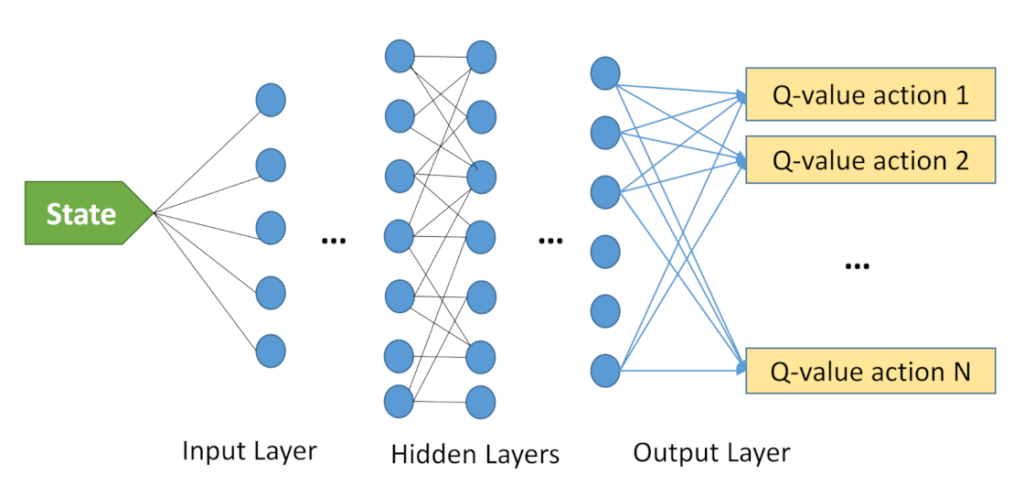

Architecture: 
- Input Layer: Input the state of the game
- Hidden Layer 1: a fully connected layer with 128 neurons, this layer processes the state of the input layer. I chose 128 neurons because I beleive 128 is just enough to capture the complex nature of the checkers board, I think more neurons would lead to overfitting.
- Batch Norm 1: After the first hidden layer, I applied batch normalization to speed up learning and increase accuracy.
- Hidden Layer 2: This is another fully connected layer with 128 neurons.
- Batch Norm 2: Apply batch normalization for the same reasons as before.
- Output Layer: A fully connected layer with a number of neurons equal to the number of possible actions. It outputs Q-values for each action given the current state of the checkers game.

In [ ]:
# Using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        # First fully-connected layer from state_size to 128 nodes
        self.fc1 = nn.Linear(state_size, 128)
        # Batch normalization layer after the first fully connected layer
        self.bn1 = nn.BatchNorm1d(128)
        # Second fully-connected layer with 128 nodes
        self.fc2 = nn.Linear(128, 128)
        # Batch normalization layer after the second fully connected layer
        self.bn2 = nn.BatchNorm1d(128)
        # Output layer, from 128 nodes to the number of actions in the action space
        self.fc3 = nn.Linear(128, action_size)  
    
    def forward(self, x):
        # Apply the first fully connected layer and then batch normalization
        x = self.bn1(F.relu(self.fc1(x)))
        # Apply the second fully connected layer and then batch normalization
        x = self.bn2(F.relu(self.fc2(x)))
        # The final layer outputs raw action values directly without an activation function
        x = self.fc3(x)
        return x


### Methodology: Replay Buffer

> A Replay Buffer is a data structure that stores the past experiences of the agent, each experience consists of tuples that contains the state, action, reward, next state, and a done flag indicating if the episode has ended. This buffer acts as a memory of past actions, which allows the agent to learn from its previous experiences. The experiences stored in the Replay Buffer are used to train the neural network model, which approximates the Q-values. The replay buffer will store the data that the model will be trained on, it stores different states of the game 

- `def __init__(self, capacity)`: The buffer is initialized with a maximum capacity, which is the number of experiences it can store. When this capacity is exceeded, the oldest experiences are removed and replaced with new ones. 
- `def push(self, state, action, reward, next_state, done)`: This method allows the storing of experiences in the buffer. Each experience includes the state before the action, the action taken, the reward received for the action, the new state, and whether the episode ended. These elements are converted into PyTorch tensors.
`def sample(self, batch_size)`: This method randomly samples a batch of experiences from the buffer. 
` def __len__(self)`: This method returns the number of experiences currently stored in the buffer.

Resource: https://github.com/kcg2015/DDPG_numpy_only/blob/master/ReplayBuffer.py

In [ ]:
    
class ReplayBuffer:
    """
    A class used to store the experiences of the agent.
    The buffer holds a number of the most recent experiences.
    """
    def __init__(self, capacity):
        """
        Initializes the ReplayBuffer.

        Args:
            capacity (int): The maximum number of experiences the buffer can hold. When the capacity
                            is exceeded the old experiences are discarded to make room for new ones.
        """
        # Initialize a deque with a fixed size to serve as the experience replay buffer.
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        """
        Stores an experience tuple in the replay buffer.

        Args:
            state: The state observed by the agent prior to taking the action.
            action (int): The action taken by the agent in the given state.
            reward: The reward received from the environment after taking the action.
            next_state : The state of the environment following the action.
            done (bool): indicating whether the episode has ended (True if the episode ended).
        """
        # Convert the elements of the experience to PyTorch tensors and append to the buffer.
        state = torch.tensor(state, dtype=torch.float32).to(device)
        next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
        action = torch.tensor([action], dtype=torch.int64).to(device)
        reward = torch.tensor([reward], dtype=torch.float32).to(device)
        done = torch.tensor([done], dtype=torch.uint8).to(device)

        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        """
        Samples a batch of experiences from the buffer randomly.

        Args:
            batch_size (int): The number of experiences to sample.

        Returns:
            tuple: A tuple containing batches of states, actions, rewards, next_states, and dones.
                   Each batch is a tensor containing the respective attributes from the sampled experiences.
        """

        # Randomly sample a batch of experiences from the buffer.
        transitions = random.sample(self.buffer, batch_size)
        batch = tuple(zip(*transitions))

        # Convert each batch of experiences to a PyTorch tensor and return the tuple of tensors.
        states, actions, rewards, next_states, dones = batch
        states = torch.stack(states).to(device)
        actions = torch.stack(actions).squeeze().to(device)  # Ensure actions are long type for indexing
        rewards = torch.stack(rewards).to(device)
        next_states = torch.stack(next_states).to(device)
        dones = torch.stack(dones).to(device)

        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        """
        Returns the current number of experiences stored in the buffer.

        Returns:
            int: The number of experiences in the buffer.
        """
        return len(self.buffer)
    
    def get_contents(self):
        """
        Retrieves the entire content of the buffer for inspection or debugging.

        Returns:
            list: A list containing all the experiences currently stored in the buffer.
        """
        return list(self.buffer)
    def clear_buffer(buffer):
        buffer.clear()  # This clears the deque storing the experiences

### Methodology: Agent
> The Agent is the most important part of this process. The Agent is the AI that acts on the environment, it learns from the actions it takes in the checker's environment and makes decisions while updating its knowledge so it can perform better next time. 

- `def __init__()`: The agent has many parameters that control its learning and decision-making processes.
    - *state_size*: Dimension of each state
    - *action_size*: Dimension of each action
    - *capacity*: Maximum size of the replay buffer
    - *lr* : Learning rate 
    - *batch_size*: Sample size from the replay buffer
    - *gamma*: Discount factor for future rewards
    - *epsilon*: Initial exploration rate in the epsilon-greedy policy
    - *epsilon_decay*: Multiplicative factor (per episode) for decreasing epsilon
    - *epsilon_min*: Minimum value of epsilon

- `def select_action(self, state, all_possible_moves)`: I am using an *Epsilon-Greedy Method* to select actions based on the current state. This method balances exploration, (which means the agent takes new actions that aren't based on previous experiences) and exploitation (which means the agent uses the knowledge it has gained to perform an action). This method chooses between exploration and exploitation randomly, which allows the agent to learn well. We start off training with a high epsilon which encourages exploration, as training progresses, the epsilon is decreased gradually which allows us to utilize this method.
- `step(self, state, action, reward, next_state, done)`: Handels the agents step in the environment
- `def learn(self)`: This method samples a batch of experiences and uses them to update the agent's knowledge. The agent learns using the Bellman Equation.
  -  `Bellman Equation`:
      -  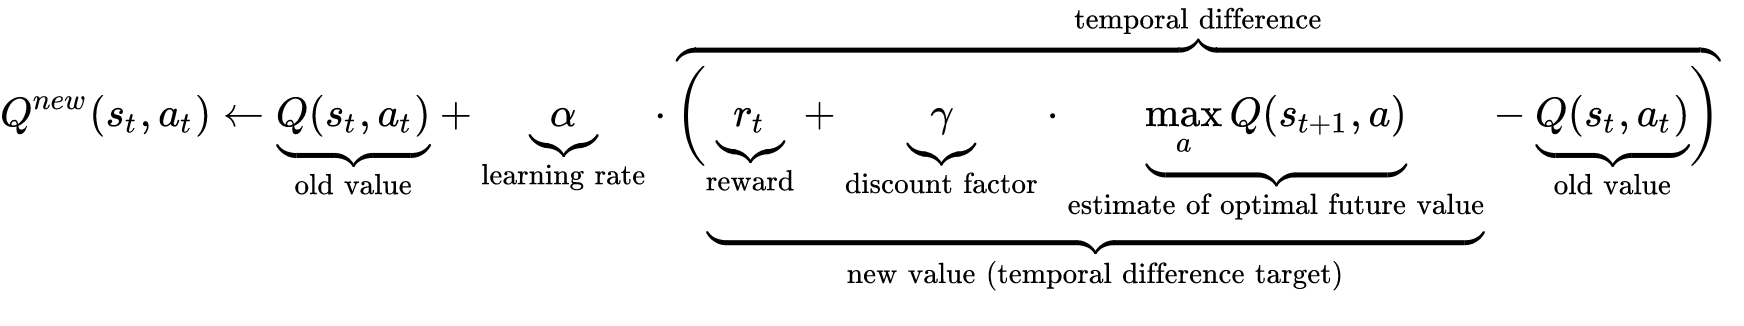
      -  *Q_expected*: The current states are passed through the policy_net to predict the Q-values for all actions, the Q-values for the actions that were taken are the expected Q-values.
      -  *Q_target*: The target Q-value is calculated using this equation, It combines the immediate rewards and the discounted maximum future rewards. The discount factor(gamma) reduces the future rewards which ensures that immediate rewards have more influence than future ones.
  -  `loss`
      - Using The Mean Squared Error (MSE), the loss is calculated between Q_expected and Q_target. This loss measures how far the agent's current action is from the optimal action, as the loss decreases, it means that the agent is learning to make optimal/desirable actions.
      - The gradient of the loss is computed and used to update the weights of the policy_net through back prop to decrease the difference between the expected and target Q-values.
  - `def update_epsilon(self)`: This method reduces the epsilon value by multiplying the epsilon with the epsilon decay.
  - `def update_target_network(self)`: updates the target network.
 
Resources: 
https://github.com/pskrunner14/trading-bot/blob/master/trading_bot/agent.py
https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/

In [ ]:
    
class Agent:
    """
    Initialize an Agent object.
    
    Attributes:
        state_size (int): The size of the input state dimension.
        action_size (int): The size of the action space.
        memory (ReplayBuffer): The replay buffer that stores experience tuples.
        batch_size (int): The size of each batch of experiences sampled from the memory.
        gamma (float): The discount rate used to attenuate future rewards.
        epsilon (float): The exploration rate for the epsilon-greedy policy, dictates the balance between exploration and exploitation.
        epsilon_min (float): The minimum value to which epsilon can decay.
        epsilon_decay (float): The rate at which the value of epsilon decays after each episode.
        policy_net (DQN): The primary network that learns the Q-function.
        target_net (DQN): The target network that predicts next state values.
        optimizer (torch.optim.Adam): The optimizer for training the policy network.
    """
    def __init__(self, state_size, action_size, capacity=500, lr=0.0001, batch_size=64, gamma=0.99, epsilon=1.0, epsilon_decay=0.99999, epsilon_min=0.00001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(capacity) # Replay buffer to store experience
        self.batch_size = batch_size
        self.gamma = gamma  # Discount factor for future rewards
        self.epsilon = epsilon  # Initial exploration rate
        self.epsilon_min = epsilon_min  # Minimum exploration rate
        self.epsilon_decay = epsilon_decay  # Decay rate for exploration probability

        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Adam Optimizer
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=lr)

        self.performance_track = []

    def select_action(self, state, all_possible_moves):
        """
        Selects an action based on the current state using an epsilon-greedy method.
        

        Parameters:
        - state: The current state of the environment.
        - all_possible_moves (list): A list of all possible actions available to the agent at the current state.

        Returns:
        - int: The index of the chosen action from the list of all possible moves. Returns None if no moves are available.
        """
        if not all_possible_moves:  # Check if there are no moves available
            return None
        # Check if there are no possible moves
        if len(all_possible_moves) == 0:
            return None  # Indicate no action is possible

        # Prepare the state input for the DQN
        state = torch.from_numpy(np.array(state).flatten()).float().unsqueeze(0).to(device)

        # Decide whether to use the model for action selection or choose randomly (epsilon-greedy)
        if random.random() > self.epsilon:
            self.policy_net.eval()
            with torch.no_grad():
                action_values = self.policy_net(state)
            self.policy_net.train()
            action_index = action_values.max(1)[1].item()  # Get action from DQN
        else:
            action_index = random.randrange(len(all_possible_moves))  # Random action

        # Ensure the index is within the bounds of available moves
        action_index = min(action_index, len(all_possible_moves) - 1)

        # Return the selected action
        return all_possible_moves[action_index]


    def step(self, state, action, reward, next_state, done):
        if action is not None:  # Only push if action is not None
            self.memory.push(state, action, reward, next_state, done)
        self.learn()
        self.update_epsilon()
        loss = self.learn()
        return loss

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        # If actions are not already indices, make them indices (assumed correct sampling)
        # For instance, if actions are one-hot encoded or in any other form, they need to be converted to indices
        if actions.size(1) != 1:
            actions = actions.argmax(dim=1) # Assuming actions are provided as one-hot or probabilities

        actions = actions.unsqueeze(1) # Make sure it is [batch_size, 1] for gather

        # Process network outputs
        policy_output = self.policy_net(states)

        # Gathering the expected Q-values for the chosen actions
        Q_expected = policy_output.gather(1, actions)

        # Calculate the loss and update
        Q_targets_next = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Epsilon update
        self.update_epsilon()
        #print(f"Loss: {loss.item()}")  # Check the loss value here
        return loss.item()
        

    def update_epsilon(self):
        self.epsilon = self.epsilon * self.epsilon_decay
        
    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

main.py 

In [ ]:

FPS = 60
WIN = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption('Checkers')
print(f"Using device: {device}")

# Used to get the users input
def get_row_col_from_mouse(pos):
    x, y = pos
    row = y // SQUARE_SIZE
    col = x // SQUARE_SIZE
    return row, col

# Used to plot the results
def plot_results(rewards, losses, epsilons):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.plot(rewards, label='Rewards per Episode')
    plt.title('Rewards')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(losses, label='Average Loss per Episode')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epsilons, label='Epsilon Values')
    plt.title('Epsilon')
    plt.legend()

    plt.pause(0.05)
    plt.show(block=True)


def main():
    pygame.init()
    win = pygame.display.set_mode((WIDTH, HEIGHT))
    pygame.display.set_caption('Checkers')
    clock = pygame.time.Clock()
    
    game = Game(win)
    agent = Agent(state_size=64, action_size=32)

    mode = input("Choose mode: 1 for AI vs AI, 2 for Human vs AI: ")

    if mode == '1':
        num_episodes = 700  # Number of games to play
        win_counts = {RED: 0, WHITE: 0}  # Track wins for each player
        # tracking variables for progress
        rewards = []  
        losses = []
        epsilons = []
        # maximum time per game (in seconds)
        max_time_per_episode = 15

        for episode in range(num_episodes):
            start_time = time.time() # start time
            game.reset() # Reset the game to the initial state
            state = game.get_state() 
            done = False
            total_reward = 0
            episode_losses = []
            move_count = 0

            while not done:
                current_time = time.time()
                elapsed_time = current_time - start_time  # Calculate elapsed time
                # End the episode if the time limit is reached
                if elapsed_time > max_time_per_episode:
                    break
                
                action = agent.select_action(np.array(state), game.generate_all_possible_moves())
                reward, done = game.perform_action(action)
                next_state = game.get_state()

                loss = agent.step(state, action, reward, next_state, done)
               
                if loss is not None:
                    episode_losses.append(loss)

                state = next_state
                total_reward += reward

                game.update()
    
                # Check for end conditions beyond winning
                if game.check_end_condition() or move_count > MAX_MOVES_ALLOWED:
                    done = True
                    
                if done:
                    winner = game.winner()
                    if winner:
                        win_counts[winner] += 1
            # Tracks progress
            avg_loss = np.mean(episode_losses) if episode_losses else 0
            losses.append(avg_loss)
            rewards.append(total_reward)
            epsilons.append(agent.epsilon)

            # prints progress every 50 episodes
            if (episode + 1) % 50 == 0:
                print(f"Episode {episode + 1} completed: Reward = {total_reward} , Average Loss = {avg_loss}, Epsilon = {agent.epsilon}")
                print(f"Win counts: {win_counts}")

            
        # saves trained model so we can play against it
        model_save_path = os.path.abspath('trained_model.pth')
        torch.save(agent.policy_net.state_dict(), model_save_path)
        if os.path.exists(model_save_path):
            print(f"Model saved  at {model_save_path}")
        else:
            print(f"Failed to save the model {model_save_path}")
        
        #plots the results
        plot_results(rewards, losses, epsilons)
        print(f"Win counts: {win_counts}")
        
    # Mode 2 is used to play against the trained model
    elif mode == '2':
        # Load the model, change the name for different model
        model_path = os.path.abspath('trained_model.pth')
        if os.path.exists(model_path):
            agent.policy_net.load_state_dict(torch.load(model_path))
            agent.policy_net.eval()  # Set the model to evaluation mode
            print("Loaded trained model.")
        else:
            print(f"No trained model found at {model_path}, please train one first.")
            return  # Exit the mode if the model is not found
        run = True
        while run:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    run = False

                if game.turn == RED:  # Human's turn
                    if event.type == pygame.MOUSEBUTTONDOWN:
                        pos = pygame.mouse.get_pos()
                        row, col = get_row_col_from_mouse(pos)
                        game.select(row, col)

                if game.turn == WHITE:  # AI's turn
                    action = agent.select_action(np.array(game.get_state()), game.generate_all_possible_moves())
                    if action is not None:
                        game.perform_action(action)
                        game.update()
                        pygame.display.update()
                    if game.winner() is not None:
                        print("Winner:", game.winner())
                        run = False

                game.update()
                pygame.display.update()
                clock.tick(FPS)
                
    pygame.quit()

if __name__ == "__main__":
    main()

Using device: cuda


Choose mode: 1 for AI vs AI, 2 for Human vs AI:  1


Episode 50 completed: Reward = 415 , Average Loss = 3.690323251033948, Epsilon = 0.16037414993798246
Win counts: {(255, 0, 0): 11, (255, 255, 255): 34}
Episode 100 completed: Reward = 60 , Average Loss = 5.2902207061648365, Epsilon = 0.017168111158129117
Win counts: {(255, 0, 0): 20, (255, 255, 255): 67}
Episode 150 completed: Reward = 430 , Average Loss = 4.820332913669114, Epsilon = 0.0002934793308197633
Win counts: {(255, 0, 0): 27, (255, 255, 255): 94}
Episode 200 completed: Reward = 430 , Average Loss = 4.659913577139378, Epsilon = 1.903898711407251e-05
Win counts: {(255, 0, 0): 31, (255, 255, 255): 115}
Episode 250 completed: Reward = 415 , Average Loss = 3.2969237181047597, Epsilon = 4.2347689897053136e-07
Win counts: {(255, 0, 0): 39, (255, 255, 255): 136}
Episode 300 completed: Reward = 385 , Average Loss = 3.363295885276491, Epsilon = 2.6861862970829387e-09
Win counts: {(255, 0, 0): 44, (255, 255, 255): 157}
Episode 350 completed: Reward = 385 , Average Loss = 1.0980363829650

# Results & Analysis: 
#### Training
> I trained my model for 700 episodes/games, which took about 30 minutes. The hyperparameter choices that I found to have the best results were:
- **Learning Rate:** 0.0001, I chose a very low learning rate because I found that increasing the learning rate led to the model performing well in the beginning episodes ( around 50 episodes) and then the model would perform worse after. A learning rate of 0.0001 ensures that the model slows down the speed at which it learns and makes smaller updates to the weights.  
- **batch size:** 64, 64 is a standard batch size choice as it's not too large or too small.
- **epsilon decay:** 0.99999, I chose this decay rate because I noticed when my decay was lower for example 0.999, my model would reach the minimum, epsilon very quickly, which is not good for training as I am using an epsilon greedy method which aims to balance exploration of new actions and exploitation of learned actions. I found that 0.99999 allowed me to train my model longer without reaching the minimum epsilon.
- **epsilon min**=0.00001, for the same reasons above, to balance the exploration vs exploration, I choose a small minimum epsilon so that the model explores new actions and then slowly starts exploiting as training goes on.
> I struggled a bit with training, I noticed as I would train for longer periods, the model would fail to finish games and would take really long to finish those games with a winner, I believe this is because the model is playing as both the players, It would use its learned strategies and It would result in very long training times and draws. I also think my reward structure could use work. I tried training for around 2500 episodes but I found that the loss would be really high. 
#### Results
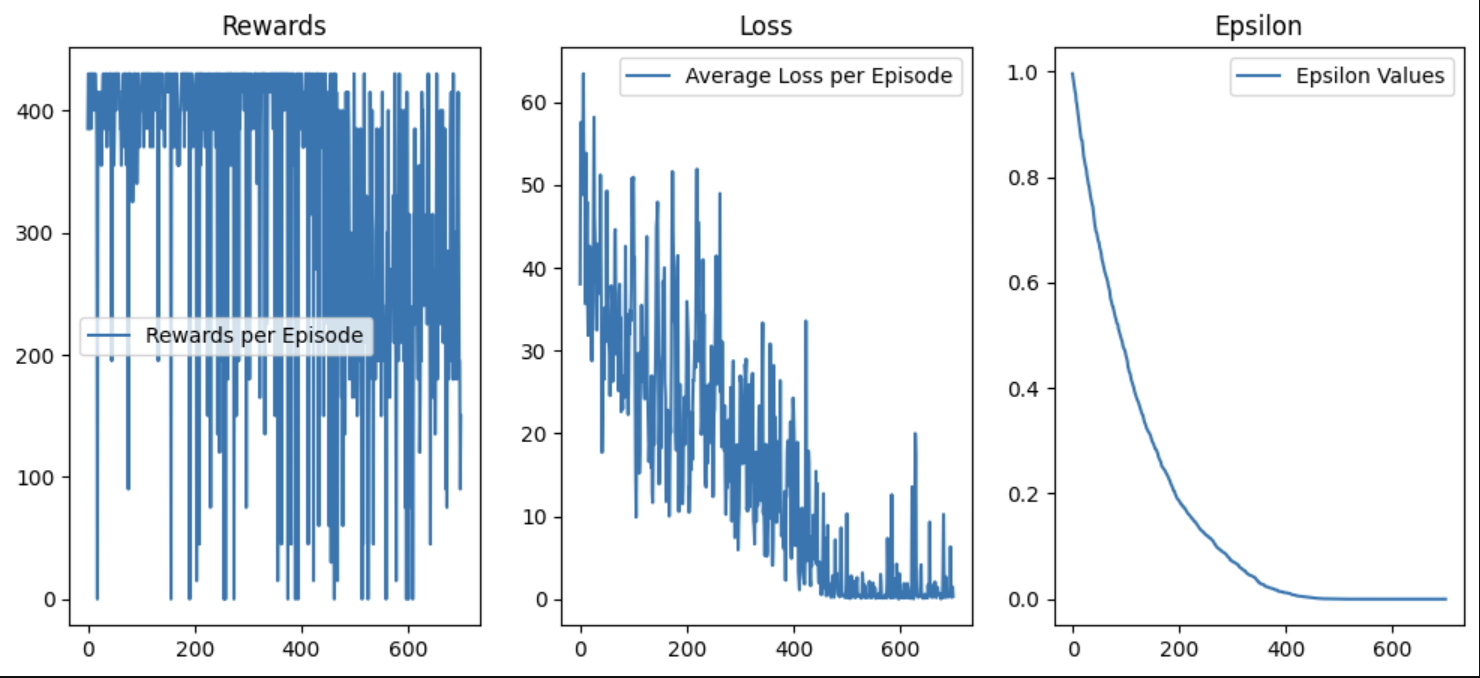

> To visualize my training progress, I measured three things, Reward, Loss, and Epsilon.
- **Loss:** My final loss average is 0.33 which is a good sign that the model is learning well. We see a decreasing trend in the loss as the episodes go on which means that the model is learning to make better predictions over time. We see a lot of oscillating because the model Is still exploring new strategies and movements, but the general trend is downwards which is a good sign that the model is learning.
- **Reward:** I measured how many rewards the model accumulated over the game. There is also a lot of oscillating because of exploration, we can see that there is a range of rewards that the model achieves regularly, but this does not necessarily mean that the model has learned to achieve the best or most optimal decisions, I also see a downwards trend in the rewards, near the end of testing, the rewards decreased, this could be just a part of the learning process as it wasn't trained on thousands of games, It could also indicate that the model is focussing too much on future rewards instead of the immediate rewards. 
- **Epsilon:** We can see the epsilon decay gradually as the episodes go on and It reaches the minimum epsilon which means the agent is not exploring new options and relying on what It learned. As epsilon decreases we see that the loss also decreases, this means that the difference between the Q expected and Q target values are decreasing which means that the model is doing better to reach the target Q value as it relies on its learned knowledge.  


#### Testing
>To test my model, I used myself as data. I played against my model for 100 games to see how it measures up to an intermediate human checkers player. (I am not an expert checkers player but I would say I know the rules well and I know how to play checkers well).To measure performance I manually tracked the win-loss ratio between myself and my model. I dont think this was the best way to test the model, but it allowed me to see where my model was lacking and what future improvements I could make. 
- The results were **3 wins by the model, 1 draw, and 96 wins by myself**.
- As you can see the model did not really measure up to an intermediate human player. I noticed many things as I was playing against my model.
- The first thing I noticed was that It did not make the best decisions in all cases, sometimes the model would make the best choice such as taking one of my pieces without sacrificing its own piece, but many times It didn't make the best choice. The model did not perform too well in capturing the opponent's pieces.
- I noticed that the model did well defensively though, near the end of the game, the model would try to avoid getting captured by my king pieces which I noticed was a common trend throughout the games. This is probably a pattern the model learned throughout the training.
- The model also did well in making its own pieces king pieces.


#### Other training results: 
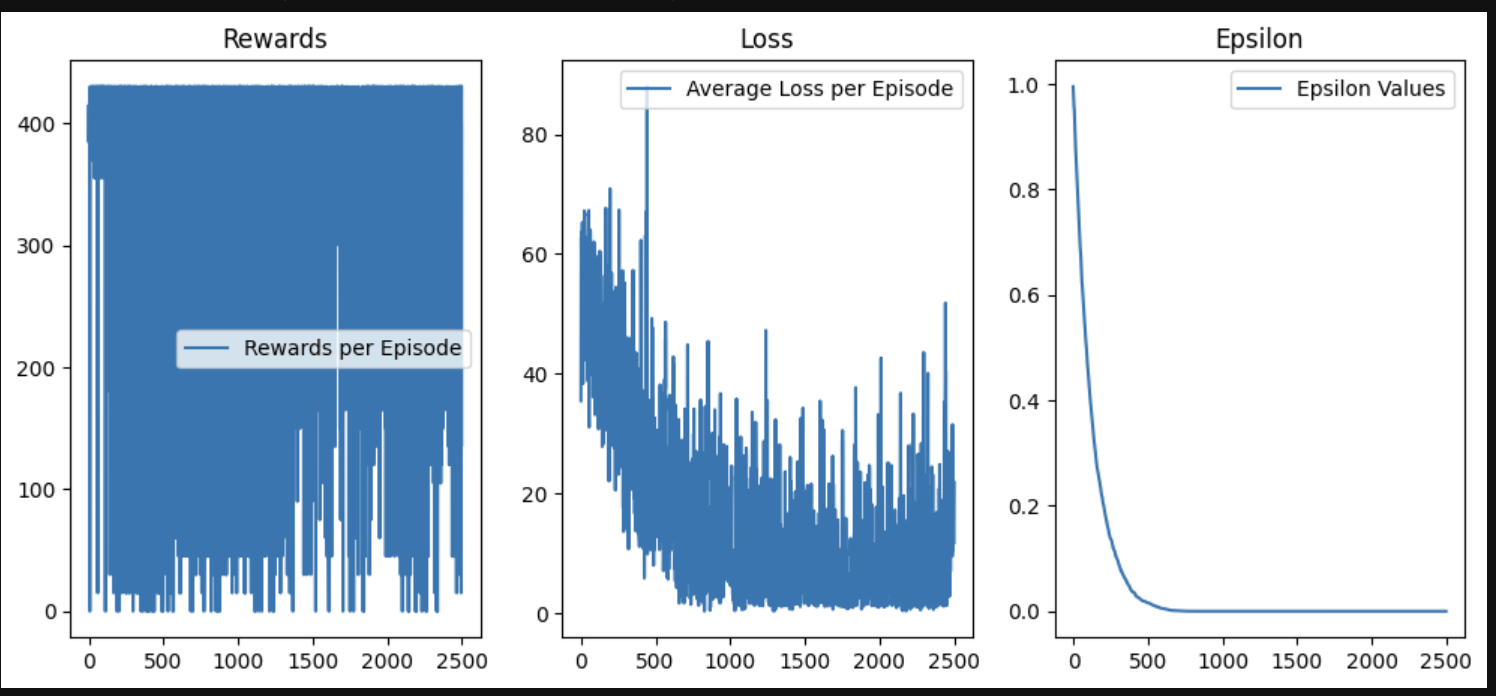
>These were my results for training with 2500 episodes, as you can see, the loss is very high, but we can see the epsilon decaying gradually, another difference is that the model is gaining more rewards as the training goes on, this is probably due to more training. I experimented with different hyperparameter settings such as slower epsilon decay so the model could explore more, and tried higher and lower learning rates but I still couldn't get good results.     

# Conclusion
>In this project, my goal was to create a checker AI capable of playing against a human player and performing well. The AI is a deep neural network, structured to evaluate states and determine the most optimal moves. The training was conducted over 700 episodes, where the AI played against itself, constantly learning and adapting its strategy through reinforcement learning techniques. I used Deep Q learning which is a method where a model learns how to make the best optimal decision in an environment, using this method I trained my model, I would conclude that my model did not reach the final goal of performing at an intermediate level, I believe that the model is fairly competent, but it needs a lot of improvements in order to reach higher levels of gameplay. The model does not make the most optimal choice in a game of checkers. This model is decent and can play checkers at a very beginner level (I would compare the model to a child who just learned how to play the game), but It will most likely lose to anyone who actually knows how to play checkers.
> To play against the trained model, download the trained_model.pth and choose mode 2 (Jupyter Notebooks cannot run pygames so you would have to use another IDE such as VSCode and copy and paste all the code). 
#### Learning outcomes: 
- In this project, I learned what Q learning is, which is a reinforcement learning technique used to learn desirable actions given a particular state. I learned how to combine deep learning and reinforcement learning with Deep Q-learning, which uses deep neural networks to get adjust Q-values based on previous experiences.
- Another major part of this project was the epsilon greedy method which handles the balance between exploration and exploitation, I learned how to tune hyperparameters to achieve this balance.
- I also learned how to design a reward system by experimenting with different strategies such as positive rewards for capturing pieces and negative rewards for losing pieces and so on. 
#### Future Work
- Experimenting with different network architectures could improve the Agent's ability to make better strategic decisions.
- Having another Agent could improve my model, this other agent could learn through a different strategy of checkers and I can make these two agents play against each other to create a better overall model.
- Change the reward system, I would like to add a lot more reward metrics for the agent, and test different strategies.
- With these changes, I would train the model for a lot longer, perhaps multiple days of training over tens of thousands of games would lead to the model learning more strategies and overall improving its ability to play checkers.


Resources: 
- https://blog.paperspace.com/building-a-checkers-gaming-agent-using-neural-networks-and-reinforcement-learning/
- https://www.youtube.com/watch?v=x83WmvbRa2I
- https://medium.com/iecse-hashtag/rl-part-5-implementing-an-iterable-q-table-in-python-a9b515c2c1a 
- https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/blob/master/Chapter%203/Ch3_book.ipynb
- https://www.w3schools.com/python/ref_func_any.asp
- https://www.youtube.com/watch?v=OYhFoMySoVs&t=1519s
- https://pytorch.org/tutorials/beginner/saving_loading_models.html
- https://huggingface.co/learn/deep-rl-course/en/unit3/deep-q-algorithm
